# Comparing spatiotemporal stability of illumination sources 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
import scipy.signal
import pandas as pd
import glob
import sys
import seaborn as sns
import os
import matplotlib.gridspec as gridspec
sys.path.insert(0, '../../')
import mwc.image
import mwc.viz
import mwc.stats
colors = mwc.viz.personal_style()
%matplotlib inline

## The problem 

To examine why the determination of a calibration factor is dependent on the illumination source, I decided to compare and contrast the stability of the illumination over time and space. Over the course of a few days, I took images of a fluorescent slide for 100 frames at one position as well as at multiple positions. These images were taken on all thre illumination sources -- a 589nm laser, a mercury lamp, and an LED.

I also imaged the spatial stability of the Hg lamp and the laser by imaging fluorescent beads rasterized over the field of view. I have not yet done this for the LED system.

##  Data processing

The first step is to load in the images and extract the fluorescence information. I will store this as a Pandas DataFrame

In [195]:
# Define the data directories. 
hg_data = glob.glob('../../data/images/20180206_hermes_lamp_stability/20180206_fluorescent_stability_test_0/*Cherry*.tif')
lam_data = glob.glob('../../data/images/20180207_artemis_laser_stability/201802027_mcherry_single_pos_1/Pos0/*TRITC*.tif')
led_data = glob.glob('../../data/images/20180208_tenjin_led_stability/*single_pos2*.TIF')
data = [hg_data, lam_data, led_data]
method = ['hg', 'laser', 'led']
# Set up the DataFrame
df = pd.DataFrame([], columns=['method', 'idx', 'time', 'total_intensity', 'mean_intensity', 'image_area', 'center_pix'])

# Loop through the datafiles and compute the properties of interest. 
shot_noise = {}
for i, d in enumerate(data):
    # Sort the datafile.
    sorted_vals = np.sort(d)
    
    # Iterate through each image and compute the properties.
    for j, f in enumerate(sorted_vals):            
        im = skimage.io.imread(f)
        area = np.prod(im.shape)
        total = np.sum(im)
        mean = np.mean(im)
        im_shape = np.shape(im)
        if j==0:
            shot_noise[method[i]] = im[(int(im_shape[0] / 2) - 5):int(im_shape[0] / 2) + 5,
                                      int(im_shape[1] / 2) - 5: int(im_shape[1] / 2) + 5]
        center_pix = im[int(im_shape[0] / 2), int(im_shape[1] / 2)]
        
        t_dict = {'idx':i, 'method': method[i], 'time':j, 'total_intensity':total,
                 'mean_intensity': mean, 'image_area': area, 'center_pix':center_pix}
    
        df = df.append(t_dict, ignore_index=True)

KeyboardInterrupt: 

##  Comparison

In [ ]:

# Group by method. 
grouped = df.groupby('method')

# Set up a three row plot showing the total intensity as a function of time. 
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(8,3))

# Set up a dictionary for the plotting.
ax_dict = {'laser':0, 'hg':1, 'led':2}

ax[0].set_title('589nm laser')
ax[1].set_title('Hg lamp')
ax[2].set_title('LED')

ax[0].set_ylabel('total intensity')

# Iterate through the grouped dataframe and plot the raw data. 
for g, d in grouped:
    ax[ax_dict[g]].plot(d['time'], d['total_intensity'], '-')
    ax[ax_dict[g]].set_ylim([d['total_intensity'].min(), d['total_intensity'].max()])
    
for a in ax:
    a.set_xlabel('frame number')
    a.set_xlim([0, 100])

sns.despine(offset=7)
plt.tight_layout()

In [ ]:
# Compute the differences. 
fig, ax = plt.subplots()
ax.set_xlabel('Δ frame number')
ax.set_ylabel('fractional differenc')
ax.set_xlim([0, 100])
# Set up a dictionary for the plotting. 
for g, d in grouped:
    _ = ax.plot(d['time'][:-1], np.diff(d['total_intensity']) / d.total_intensity.values[:-1], '-', label=g)
    

_ = ax.legend()
sns.despine(offset=7)
plt.tight_layout()

As I had gathered from my misery, it appears that the mercury lamp is more stable than the laser or even the LED. We can take a look at the distributions of this difference below.

In [ ]:
# Compute the ECDF distributions of these percent differences.
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('% difference')
ax.set_ylabel('empirical cumulative distribution')
mean_sq_diff = {}
for g, d in grouped:
    diff = np.diff(d['total_intensity']) / d['total_intensity'].values[:-1]
    mean_sq_diff[g] = np.mean(np.abs(diff))
    x, y = mwc.stats.ecdf(diff) 
    _ = ax.plot(x * 100, y, '.', ms=3, label='{0} - {1:0.2f} %'.format(g, mean_sq_diff[g] * 100))
_l = ax.legend(title = 'mean % difference')
_l.get_title().set_fontsize(8)
sns.despine(offset=7)
 

It looks like the LED is more stable if those large jumps in intensity weren't occurring. HJ believes that this is a characteristic sign of shitty electronics and bets that frequency is 60Hz. Because I went back and forth between filter sets, I'm not 100% sure of the sampling frequency. As such, I can't compute the fourier transform to figure it out. However, this is something that I can take another shot at.  

In [ ]:
im = skimage.io.imread(hg_data[80])
skimage.io.imshow(im)

In [ ]:
im

##  Computing the error measurements. 

I can look at teh distribution of mean image values. 


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
axes = {'hg':ax[0], 'led':ax[1], 'laser':ax[2]}
idx = {'hg':0, 'laser':1, 'led':2}
rescaled = {}
means = {}
stds = {}
for i, g in enumerate(axes.keys()):
    x, y = mwc.stats.ecdf(shot_noise[g].flatten())
    centered = x / np.mean(x) 
    centered -= np.mean(centered)
    rescaled[g] = centered
    means[g] = np.mean(centered)
    stds[g] = np.std(centered)
    
    axes[g].plot(centered, y, '.')

In [ ]:
# Set up the figure canvas.
fig, ax = plt.subplots(2, 3, figsize=(6, 3.75))
for i in range(3):
    ax[0, i].axis('off')
    ax[1,i].set_xlabel('centered pixel value')
for i in range(1, 3):
    ax[1, i].set_yticklabels([]) 
ax[0, 0].set_title('Hg lamp') 
ax[0, 1].set_title('LED') 
ax[0, 2].set_title('589 nm laser') 
ax[1, 0].set_ylabel('cumulative distribution')
ax[0,0].text(-0.5, 1.05, '(A)', transform=ax[0,0].transAxes, fontsize=8)
ax[1,0].text(-0.5, 1.05, '(B)', transform=ax[1,0].transAxes, fontsize=8)
ax[1,0].text(0.05, 0.8, 'µ = {0:0.0f}\nσ = {1:0.3f}'.format(means['hg'], stds['hg']),
            fontsize=8, transform=ax[1,0].transAxes)
ax[1,1].text(0.05, 0.8, 'µ = {0:0.0f}\nσ = {1:0.3f}'.format(np.abs(means['led']), stds['led']),
            fontsize=8, transform=ax[1,1].transAxes)
ax[1,2].text(0.05, 0.8, 'µ = {0:0.0f}\nσ = {1:0.3f}'.format(np.abs(means['laser']), stds['laser']),
            fontsize=8, transform=ax[1,2].transAxes)

# Images
_ = ax[0, 0].imshow(shot_noise['hg'])
_ = ax[0, 1].imshow(shot_noise['led'])
_ = ax[0, 2].imshow(shot_noise['laser'])

# CDFs
hg_x, hg_y = mwc.stats.ecdf(rescaled['hg'].flatten())
led_x, led_y = mwc.stats.ecdf(rescaled['led'].flatten())
laser_x, laser_y = mwc.stats.ecdf(rescaled['laser'].flatten())

_ = ax[1, 0].plot(hg_x, hg_y, '.', ms=2.5, label='data')
_ = ax[1, 1].plot(led_x, led_y, '.', ms=2.5)
_ = ax[1, 2].plot(laser_x, laser_y, '.', ms=2.5)

#Gaussian Approx 
x_range = np.linspace(-0.06, 0.05, 500)
hg_approx = scipy.stats.norm.cdf(x_range, means['hg'], stds['hg'])
led_approx = scipy.stats.norm.cdf(x_range, means['led'], stds['led'])
laser_approx = scipy.stats.norm.cdf(x_range, means['laser'], stds['laser'])
_ = ax[1, 0].plot(x_range, hg_approx, '-', lw=1)
_ = ax[1, 1].plot(x_range, led_approx, '-', lw=1)
_ = ax[1, 2].plot(x_range, laser_approx, '-', lw=1)
mwc.viz.format_axes()
plt.subplots_adjust(hspace=0.01)
plt.savefig('../../figs/shot_noise_measurement.pdf', bbox_inches='tight')

## Temporal variation 

Calculate all pairwise differences from frame to frame

In [ ]:
grouped = df.groupby('method')
fig = plt.figure(figsize=(6, 3.5))
gs = gridspec.GridSpec(2, 3)

ax4 = plt.subplot(gs[1, 0])
ax5 = plt.subplot(gs[1, 1])
ax6 = plt.subplot(gs[1, 2])
ax = [ax4, ax5, ax6]

# fig, ax = plt.subplots(1,3, figsize=(6,2.5))
ax[0].set_title('Hg lamp')
ax[1].set_title('LED')
ax[2].set_title('589 nm laser')
axes = {'hg':ax[0], 'led':ax[1], 'laser':ax[2]}
fun_im = np.zeros((9, 100))
ind = {'hg': 0, 'led': 3, 'laser':6}
for g, d in grouped:

    fun_im[ind[g]:ind[g]+3, :]= d['center_pix'].values / d['center_pix'].mean()
#     vals = d['center_pix'].values / d['center_pix'].mean()
#     vals = vals.astype(float)
#     ind[g].imshow(np.array([vals, vals]))
    x, y = mwc.stats.ecdf(d['total_intensity'] / d['total_intensity'].mean())
    mean_x = np.mean(x)
    std =  np.std(x)
    val_range = np.linspace(0.97, 1.05, 500)
    approx = scipy.stats.norm.cdf(val_range, mean_x, std)
    _ = axes[g].plot(x, y, '.', ms=2)
    _ = axes[g].plot(val_range, approx)
    axes[g].text(0.02, 0.85, "μ = {0:0.3f}\nσ = {1:0.3f}".format(mean_x, std),
                 transform=axes[g].transAxes, fontsize=8)


ax1 = plt.subplot(gs[0, :])
ax1.set_yticks([1, 4, 7])
ax1.set_yticklabels(['Hg', 'LED', 'laser'])
ax1.set_title(r'frame number $\longrightarrow$')
ax1.set_xticks([])
ax1.grid(False)
ax1.imshow(fun_im, vmin=0.9, vmax=1.1)
mwc.viz.format_axes()
ax1.spines['bottom'].set_visible(False)
ax1.text(-0.12, 1.1, '(A)', fontsize=8, transform=ax1.transAxes)
ax4.text(-0.48, 1.1, '(B)', fontsize=8, transform=ax4.transAxes)
ax5.set_yticklabels([])
ax6.set_yticklabels([])
plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()
plt.savefig('../../figs/temporal_noise_measurement.pdf', bbox_inches='tight')

## Spatial variation

In [ ]:
# Load fluorescence slide image sets.
led_slides = glob.glob('/Volumes/GDC_DATA_2/mwc_growth_data/20180209_tenjin_37C_glucose_O2_dilution/originals/*slide_w1*.TIF')
hg_slides = glob.glob('../../data/images/20180214_hermes_37C_glucose_O2_dilution/*fluorescent_slide*/Pos*/*mCherry*.tif')
laser_slides = glob.glob('../../data/images/20180123_artemis_37C_glucose_O2_dilution/*TRITC_*slide*/Pos*/**.tif')

# load all of the images and create the avergage porjection.
led_slide_ims = skimage.io.ImageCollection(led_slides)
hg_slide_ims = skimage.io.ImageCollection(hg_slides)
laser_slide_ims = skimage.io.ImageCollection(laser_slides)

avg_led = mwc.image.projection(led_slide_ims, median_filt=False)
avg_hg = mwc.image.projection(hg_slide_ims, median_filt=False)
avg_laser = mwc.image.projection(laser_slide_ims, median_filt=False)

In [ ]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(avg_led)
ax[1].imshow(avg_hg)
ax[2].imshow(avg_laser)

In [ ]:
# Flatten an example image. 
dark_led = np.zeros_like(avg_led)
dark_coolsnap = np.zeros_like(avg_hg)

flat_led = mwc.image.generate_flatfield(led_slide_ims[4], dark_led, avg_led, median_filt=False)
flat_hg = mwc.image.generate_flatfield(hg_slide_ims[6], dark_coolsnap, avg_hg, median_filt=False)
flat_laser = mwc.image.generate_flatfield(laser_slide_ims[5], dark_coolsnap, avg_laser, median_filt=False)

In [ ]:
# fig, ax = plt.subplots(1, 1)
plt.imshow(avg_laser, vmin=1700, vmax=1900)
plt.colorbar()
# ax[1].imshow(flat_hg)
# ax[2].imshow(flat_laser)

In [ ]:
plt.plot()

In [ ]:
plt.imshow(flat_led)

In [ ]:
fig, ax = plt.subplots(3, 2, sharey=True)

def compute_avg_profile(stack, field_im, axis=0, return_avg=False):
    noise_im = np.zeros_like(stack[0])
    n_ims = len(stack)
    avg_im = np.zeros((n_ims, stack[0].shape[axis - 1]))
    ims = []
    for i, im in enumerate(stack):
        im_flat = mwc.image.generate_flatfield(im, noise_im, field_im, median_filt=False)
        ims.append(im_flat)
        avg = np.mean(im_flat, axis=axis) 
        avg_im[i, :] = avg 
    avg_im = avg_im / np.mean(field_im)
    if return_avg == True:
        return avg_im, np.mean(np.array(ims), axis=0)
    else:
        return avg_im

avg_axes = [0, 1]
samples = [hg_slide_ims,led_slide_ims, laser_slide_ims]
field_ims = [avg_hg, avg_led, avg_laser]
sources = ['Hg lamp', 'LED', '589 nm laser']
xdim_profiles = {}
ydim_profiles = {}
xmeans = {}
ymeans = {}
for i, a in enumerate(avg_axes):
    for j, s in enumerate(samples):
        profile = compute_avg_profile(s, field_ims[j], axis=a) 
        if a == 0:
            xdim_profiles[sources[j]] = profile
        else:
            ydim_profiles[sources[j]] = profile
            
        x = np.arange(0, profile.shape[1]) * 0.065
        mean_x = []
        mean_y = []
        for k in range(profile.shape[0]):
            if a==0:
                mean_x.append(profile[k,:])
            else:
                mean_y.append(profile[k, :])
            ax[j, i].plot(x, profile[k,:], linewidth=0.75, color=colors[0], alpha=0.3)
        if a ==0:
            xmeans[sources[j]] = np.array(mean_x).flatten()
        else:
            ymeans[sources[j]] = np.array(mean_y).flatten()
       
ax[2,0].vlines(2, 0.6,1.3, 'r')
mwc.viz.format_axes()
plt.tight_layout()

In [ ]:
two_micron = int(4 / 0.065)

In [ ]:
xdim_diffs = {}
ydim_diffs = {}
for key, val in xdim_profiles.items():
    diffs = [] 
    for i, v in enumerate(val):
        _diffs = []
        for j in range(len(v) - two_micron):
            slc = v[j:j+two_micron + 1]
            std = np.var(slc - np.mean(slc))
            _diffs.append(std)
        diffs.append(_diffs) 
    xdim_diffs[key] = np.array(diffs)

    
    

In [ ]:
fig, ax  = plt.subplots(1, 3, sharex=True, sharey=True)
axes = {'Hg lamp': ax[0], 'LED': ax[1], '589 nm laser':ax[2]}
for key, val in xdim_diffs.items():
#     means = []
#     for i, v in enumerate(val):
#         means.append(np.mean(v))
    x, y = mwc.stats.ecdf(val.flatten())
    print(key, np.mean(val.flatten()), np.std(val.flatten()))
    axes[key].step(x, y,label=key, where='post', color=colors[0], alpha=0.5)
# ax.legend()
    

In [ ]:
a, b = compute_avg_profile(laser_slide_ims, avg_laser, return_avg=True)

In [ ]:
plt.imshow(b)
plt.colorbar()

### Bead rasters 

In [ ]:
hg_beads = glob.glob('../../data/images/20180228_ito_slide/ITO*/*/*.tif')
ims = skimage.io.ImageCollection(hg_beads)
avg_hg_beads = np.mean(ims, axis=0)

flat_hg_beads = []
for i, im in enumerate(ims):
    zeros = np.zeros_like(im)
    flat = mwc.image.generate_flatfield(im, zeros, avg_hg_beads)
    flat_hg_beads.append(flat)

In [ ]:
prof = compute_avg_profile(ims[50:], avg_hg_beads)

In [ ]:
fig, ax = plt.subplots(1,1)
for i, v in enumerate(prof):
    ax.plot(np.arange(0, len(v)) * 0.163, v, '-', color=colors[0], alpha=0.5, lw=0.5)

In [ ]:
def compute_avg_profile(stack, field_im, axis=0, return_avg=False):
    noise_im = np.zeros_like(stack[0])
    n_ims = len(stack)
    avg_im = np.zeros((n_ims, stack[0].shape[axis - 1]))
    ims = []
    for i, im in enumerate(stack):
        im_flat = mwc.image.generate_flatfield(im, noise_im, field_im, median_filt=False)
        ims.append(im_flat)
        avg = np.mean(im, axis=axis) 
        avg_im[i, :] = avg 
#         avg_im = avg_im / np.mean(avg_im)
    if return_avg == True:
        return avg_im, np.mean(np.array(ims), axis=0)
    else:
        return avg_im


In [ ]:
laser_ito = glob.glob('../../data/images/20180228_ito_slide/ITO*/*/*.tif')
ims = skimage.io.ImageCollection(laser_ito)
avg_ito = np.mean(ims, axis=0)


flat_ito = []
for i, im in enumerate(ims):
    zeros = np.zeros_like(im)
    flat = mwc.image.generate_flatfield(im, zeros, avg_hg_beads)
    flat_ito.append(flat)

In [ ]:
prof = compute_avg_profile(ims, avg_hg_beads)

In [ ]:
fig, ax = plt.subplots(1,1)
for i, v in enumerate(prof):
    ax.plot(np.arange(0, len(v)) * 0.163, v, '-', color=colors[0], alpha=0.5, lw=0.5)

In [ ]:
plt.imshow(flat_ito[0])
plt.colorbar()

In [ ]:
plt.imshow(ims[10], vmin=6500, vmax=7000)
plt.grid(False)
plt.colorbar()

In [ ]:
plt.imshow(avg_ito, vmin=5000, vmax=7000)
plt.grid(False)
plt.colorbar()

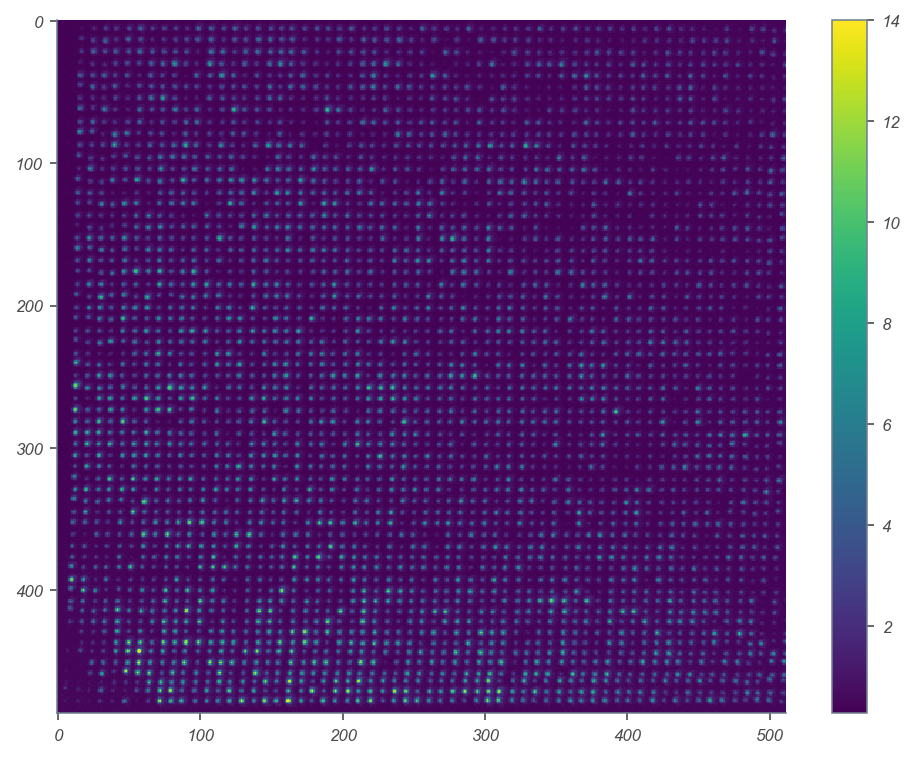

In [198]:
max_proj = skimage.io.imread('../processing/microscopy/20180302_artemis_field_mapping/output/max_projection.tif')
field_files = glob.glob('/Users/gchure/smb/artemis/20180302/ito_slide_1/Pos*/*.tif')
avg_field= np.mean(skimage.io.ImageCollection(field_files), axis=0)
zeros = np.zeros_like(avg_field)
flat_proj = mwc.image.generate_flatfield(max_proj, zeros, avg_field, median_filt=False)
plt.imshow(flat_proj[25:, :] / np.mean(flat_proj[25:, :]))
plt.grid(False)

plt.colorbar()


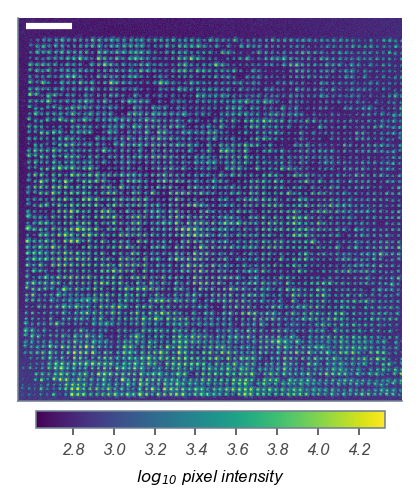

In [218]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(np.log10(flat_proj))#, vmin=900, vmax=20000)
plt.hlines(10, 10, 10 + 10/0.163, color='w', lw=3)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.colorbar(pad=0.02, orientation='horizontal', shrink=.75).set_label('$\log_{10}$ pixel intensity')
# mwc.viz.format_axes()
plt.savefig('../../figs/max_projection.pdf')

In [204]:
plt.colorbar?

In [57]:
phase_im = skimage.io.imread('/Users/gchure/Desktop/img_000000036_Brightfield_000.tif')


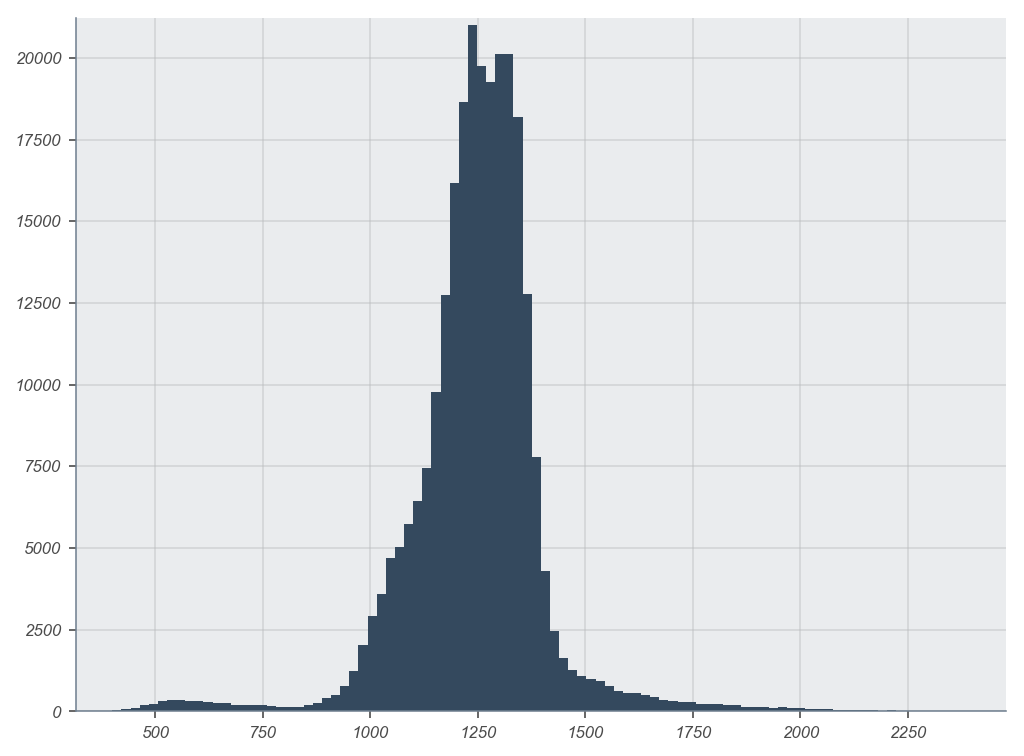

In [58]:
_ = plt.hist(phase_im.flatten(), bins=100)

In [61]:
seg = phase_im < 700
boundaries = skimage.measure.find_contours(seg, level=0)

In [66]:
skimage.measure.find_contours?

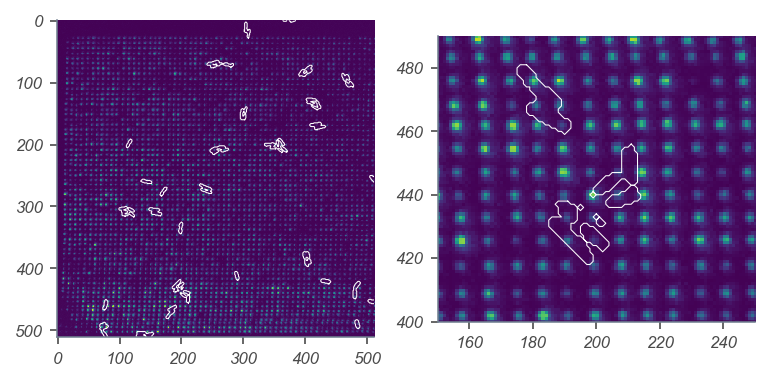

In [76]:
fig, ax = plt.subplots(1,2, figsize=(6,5))
ax[0].imshow(flat_proj)
for c in boundaries:
    ax[0].plot(c[:, 1], c[:, 0], 'w-', lw=0.5)
ax[1].imshow(flat_proj)
for c in boundaries:
    ax[1].plot(c[:, 1], c[:, 0], 'w-', lw=0.5)
ax[1].set_xlim([150, 250])
ax[1].set_ylim([400, 490])
for a in ax:
    a.grid(False)

In [9]:
plt.imshow(boundars)

NameError: name 'boundars' is not defined

In [10]:
import skimage.feature

In [11]:
# In each trace, find the maximum
peaks = skimage.feature.peak_local_max(max_proj[25:, :], 3, threshold_abs=850)


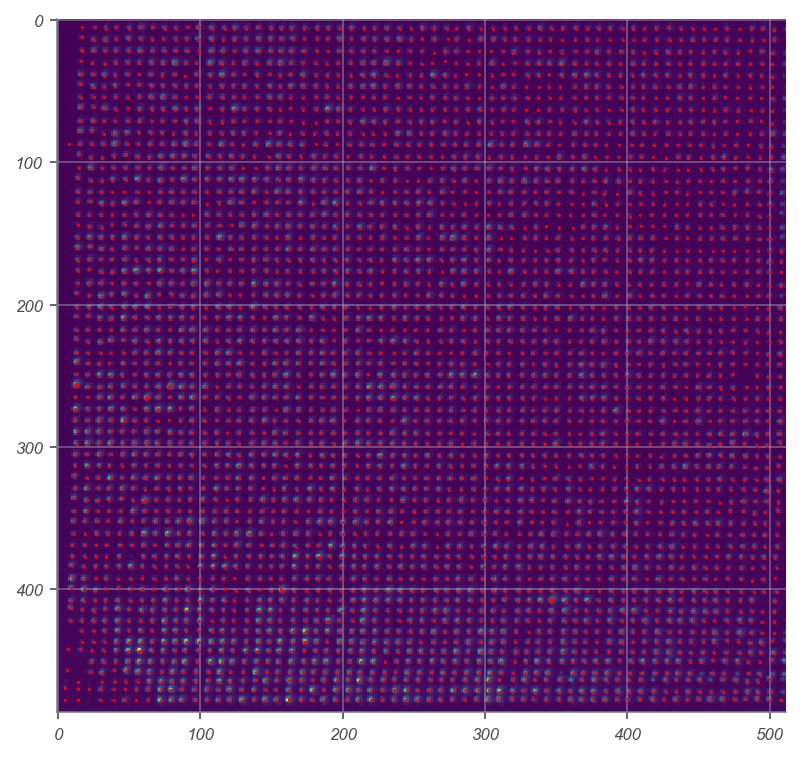

In [12]:
plt.imshow(flat_proj[25:, :])
for p in peaks:
    plt.plot(p[1], p[0], 'r.', ms=1)

In [ ]:
counts

In [ ]:
means

In [14]:
# Build a data frame of the intensities. 
trimmed = flat_proj[25:, :]
df = pd.DataFrame([], columns=['x_coord', 'y_coord', 'total_intensity', 'peak_intensity'])
num_beads = 0
for p in peaks:
    slc = trimmed[p[0]-5:p[0]+5, p[1]-5:p[1]+5]
    peak_int = np.max(slc)
    total_int = np.sum(slc)
    df = df.append(dict(x_coord=p[0], y_coord=p[1], total_intensity=total_int, peak_intensity=peak_int),
                  ignore_index=True) 
    



In [15]:
# Include an ID ref.
df['id'] = np.arange(0, len(df), 1)
neighbors = []
min_dists = []
sqdiff = []

# Find all of the nearest neighbors.
for i in range(len(df)):
    dists = np.sqrt((df['y_coord'] - df.iloc[i]['y_coord'])**2 + (df['x_coord'] - df.iloc[i]['x_coord'])**2)
    neighbor = np.where(dists == np.min(dists[dists > 0]))[0][0]
    neighbors.append(neighbor)
    min_dists.append(np.min(dists[dists > 0])) 
    sqdiff.append((df.iloc[i]['total_intensity'] - df.iloc[neighbor]['total_intensity'])**2)
    
    
df['min_dist'] = min_dists
df['neighbor'] = neighbors
df['fluct'] = sqdiff
            

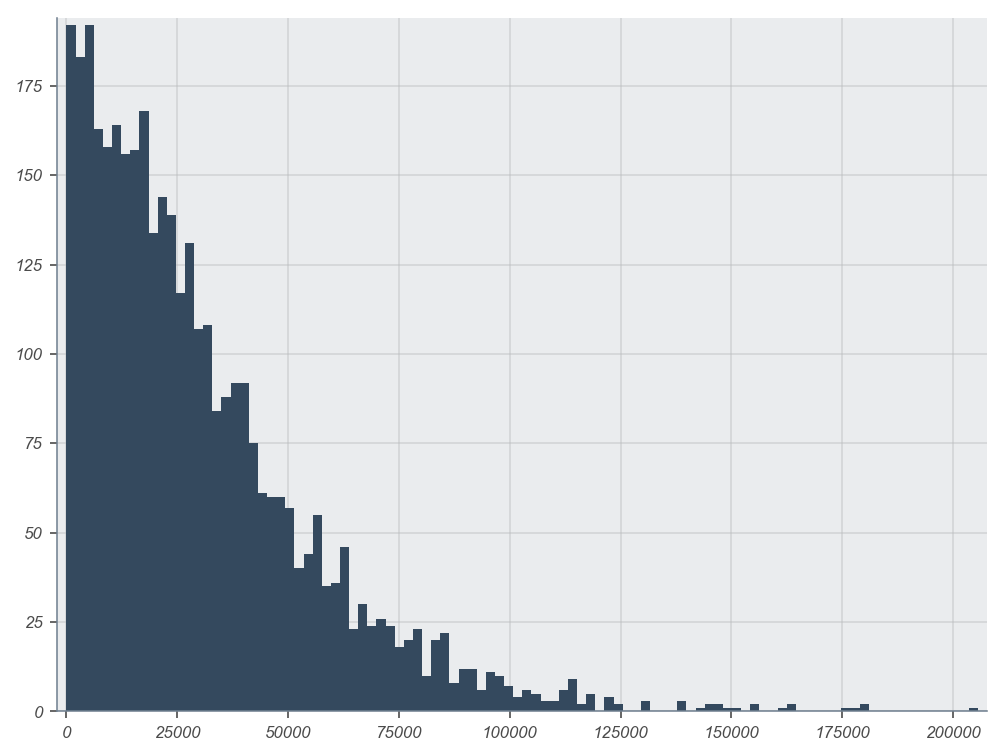

In [16]:
_ = plt.hist(np.sqrt(df['fluct']), bins=100)

In [29]:
import tqdm

In [103]:
sorted_vals = df.sort_values(['x_coord'])
# Do binning by 1 µm
bins = np.arange(0, 510, 10)
x_counts = []
y_counts = []
x_locs = []
y_locs = []
for i in tqdm.tqdm(range(1, len(bins))): 
    for j in range(1, len(bins)):
        slc = sorted_vals[(sorted_vals['x_coord'] >=  bins[i-1]) & (sorted_vals['x_coord'] < bins[i])
                         &(sorted_vals['y_coord'] >= bins[j-1]) & (sorted_vals['y_coord'] < bins[j])]
        if len(slc) > 0:
            x_counts.append(slc['total_intensity'].values[0])
            x_locs.append(bins[i])
            y_locs.append(bins[j]) 

# for i in range(len(locs)):
#     plt.plot(locs[i], counts[i])


100%|██████████| 50/50 [00:03<00:00, 14.40it/s]


In [104]:
binned_df = pd.DataFrame(np.array([x_counts, x_locs, y_locs]).T, columns=['intensity', 'xbin', 'ybin'])

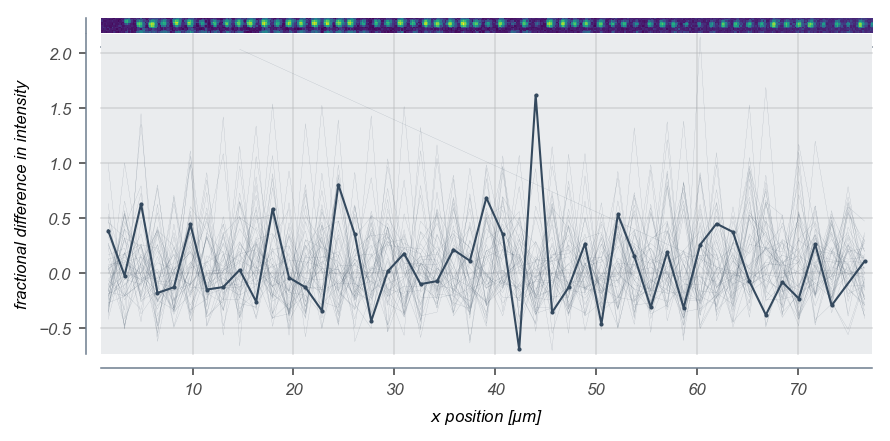

In [192]:
grouped = binned_df.groupby('ybin')
fig, ax = plt.subplots(2,1, figsize=(6, 4))
ax[1].set_xlabel('$x$ position [µm]')
ax[1].set_ylabel('fractional difference in intensity')
diffs = []
for g, d in grouped:
    sorted_vals = d.sort_values('xbin')
    if g!=20:
        lw=0.1
        alpha=0.4
        ms=0
        vals = sorted_vals['intensity']
        
    else:
        lw=1
        alpha=1
        ms=2
    diffs.append(np.abs(np.diff(sorted_vals['intensity'].values) / sorted_vals['intensity'][:-1].values))
    _ = ax[1].plot(sorted_vals['xbin'][:-1] * 0.163, np.diff(sorted_vals['intensity']) / sorted_vals['intensity'][:-1], color=colors[0], alpha=alpha, lw=lw,
           marker='.', ms=ms)

ax[0].imshow(np.log10(trimmed[10:20, :]))
ax[0].grid(False)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.subplots_adjust(hspace=-0.8)
plt.tight_layout()
mwc.viz.format_axes()
plt.savefig('../../figs/laser_spatial_fluctuations.pdf', bbox_inches='tight')

In [193]:
flat_diffs = [i for x in diffs for i in x]


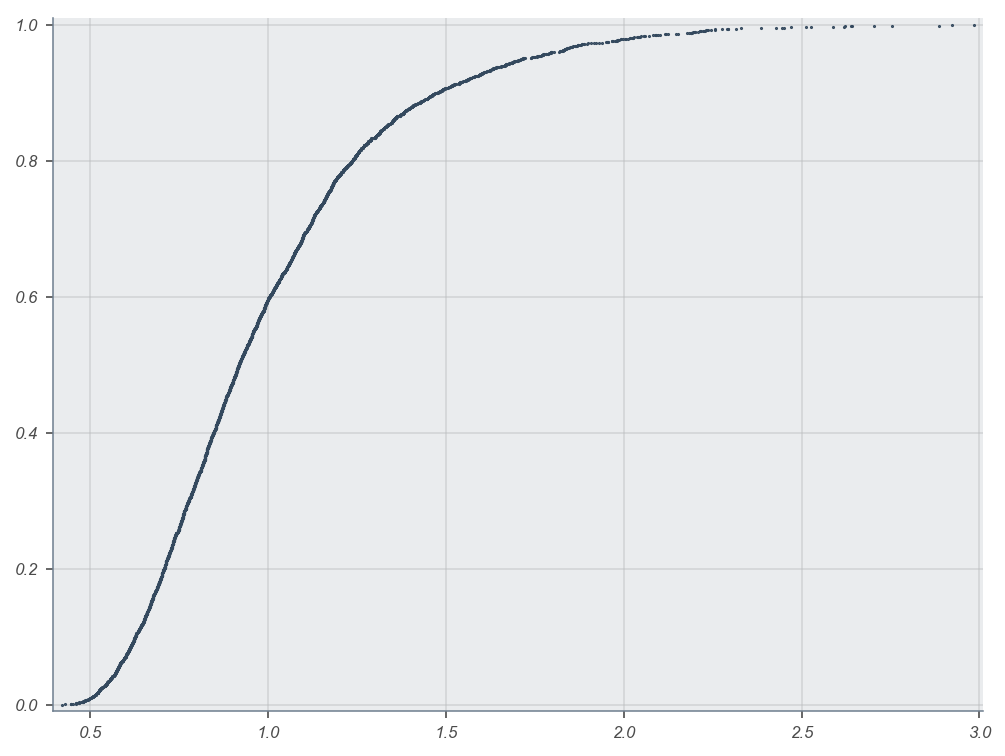

In [197]:
x, y = mwc.stats.ecdf(df['total_intensity'] / df['total_intensity'].mean())
plt.plot(x, y, '.', ms=1)


In [170]:
diffs

array([<generator object <genexpr> at 0x1c3815f518>,
       <generator object <genexpr> at 0x1c3815f6d0>,
       <generator object <genexpr> at 0x1c3815f468>,
       <generator object <genexpr> at 0x1c3815f888>,
       <generator object <genexpr> at 0x1c3815f9e8>,
       <generator object <genexpr> at 0x1c3815fb48>,
       <generator object <genexpr> at 0x1c3815fca8>,
       <generator object <genexpr> at 0x1c3815fe08>,
       <generator object <genexpr> at 0x1c3815fc50>,
       <generator object <genexpr> at 0x1c3815fa98>,
       <generator object <genexpr> at 0x1c3815f8e0>,
       <generator object <genexpr> at 0x1c3815f570>,
       <generator object <genexpr> at 0x1c3815f3b8>,
       <generator object <genexpr> at 0x1c27f630a0>,
       <generator object <genexpr> at 0x1c27f631a8>,
       <generator object <genexpr> at 0x1c3815ff10>,
       <generator object <genexpr> at 0x1c3815f200>,
       <generator object <genexpr> at 0x1c3815f938>,
       <generator object <genexpr> at 0x1c3815

In [ ]:
x, y = mwc.stats.ecdf(df['total_intensity'])
plt.plot(x,y, '.')

In [ ]:
df.head()

In [ ]:
len(ims)